# Monotone schemes in one space dimension 

This notebook illustrates the use of monotone finite difference schemes to compute viscosity solutions of PDEs, in one space dimension. (See the other notebooks for two dimensional examples.) We address both first order and second order, linear and non-linear schemes. 

For the best convenience, the numerical scheme jacobian matrix is assembled using automatic differentiation.


*Summary of this series of notebooks:*
[Adaptive grid discretizations, summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/Summary.ipynb)

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow import from parent directory
from NumericalSchemes import FiniteDifferences as fd
from NumericalSchemes import AutomaticDifferentiation as ad

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Some utility functions

In [3]:
def LInfNorm(a):
    return np.max(np.abs(np.array(a)))

In [4]:
def solve_Newton(Scheme,params,guess,print_period=1,niter=8,relax=0.):
    u = guess+ad.Sparse.identity(guess.shape)
    for i in range(niter):
        residue = Scheme(u,*params)
        if (i-1)%print_period ==0 or i==niter-1:
            print("Iteration :",i,", Residue norm :", LInfNorm(residue))
        u += (residue+relax).solve()
    return np.array(u)

In [5]:
def reload_packages():
    import importlib
    fd = importlib.reload(sys.modules['NumericalSchemes.FiniteDifferences'])
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.Sparse = importlib.reload(ad.Sparse)

## 1. A first order linear equation

We numerically compute the *viscosity* solution of the equation
$$
    f(x) - u'(x)=0
$$
over some interval, with dirichlet boundary conditions.
Unless the mean value of $f$ is compatible with the boundary conditions, then there exists no classical solution. Therefore the viscosity solution has a jump at the left endpoint. 

The monotone numerical scheme for this equation is 
$$
    f(x) - \frac{u(x+h)-u(x)} h = 0,
$$
in the interior, with the adequate boundary conditions.

The next cell defines the scheme. 

In [6]:
def Scheme(u,f,bc,gridScale):
    residue = f - fd.DiffUpwind(u,(1,),gridScale) # f-u' = 0 
    residue[0] = u[0]-bc[0]; residue[-1]= u[-1]-bc[1] # u[0]=0 and u[1]-1=0
    return residue

In [7]:
X = np.linspace(0,1,21,endpoint=True)
gridScale=X[1]-X[0]
f = np.sin(np.pi*X)
bc = (0,1)

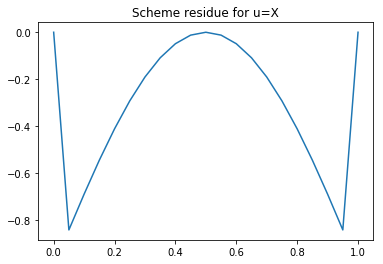

In [8]:
u=X 
residue = Scheme(u,f,bc,gridScale)
plt.title('Scheme residue for u=X')
plt.plot(X,residue);

The next step is to assemble the linear system underlying the PDE. For that purpose we rely on sparse automatic differentiation.

In [9]:
U = ad.Sparse.identity(X.shape) + X
residue = Scheme(U,f,bc,gridScale)

Finally, we solve and plot the solution. Note the (expected) discontinuity at the boundary due to the selection of the viscosity solution.

In [10]:
solution = U.value+residue.solve()
solution_residue = Scheme(solution,f,bc,gridScale)
print(LInfNorm(solution_residue))

3.3584246494910985e-15


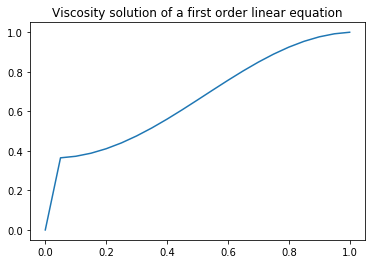

In [11]:
plt.title('Viscosity solution of a first order linear equation')
plt.plot(X,solution);

## 2. A second order linear equation

We consider the second order linear equation 
$$
    -u''(x) + a(x) u'(x) + b(x) = 0,
$$
with again Dirichlet boundary conditions.

There are two main differences w.r.t. the previous example:
* We can use centered finite differences, for the first order term, provided the grid scale is small enough. Indeed, the monotony of the second order derivative dominates the first order.
* There exists a classical solution, so the boundary conditions will be met at both endpoints.

In [12]:
def Scheme(u,a,b,bc,gridScale):
    residue = -fd.Diff2(u,(1,),gridScale) + a*fd.DiffCentered(u,(1,),gridScale) + b
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue

In [13]:
X = np.linspace(0,1,21,endpoint=True)
gridScale=X[1]-X[0]
a = 3*np.sin(np.pi*X)
b=1.
bc = (0,0.1)

In [14]:
u = ad.Sparse.identity(X.shape)
residue = Scheme(u,a,b,bc,gridScale)

In [15]:
solution = u.value+residue.solve()
print(LInfNorm(Scheme(solution,a,b,bc,gridScale)))

1.6431300764452317e-14


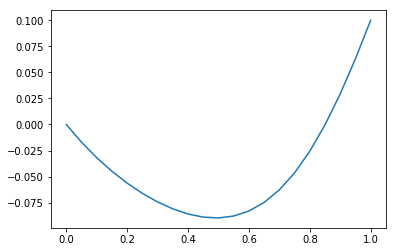

In [16]:
plt.plot(X,solution);

## 3. A non-linear equation

We consider the a non-linear equation
$$
     -a(x)u''(x)+
    d(x)|u'(x)-\omega(x)|^2 -1 = 0,
$$
where $a$ is a non-negative function. 
We use again Dirichlet boundary conditions.

When $a\equiv 0$, and $d >0$ this problem becomes a particular case of an eikonal equation, with drift $\omega$.
If $d|\omega|^2\geq 1$, somewhere in the domain, then the undelying optimal control problem looses local controllability, and a discontinuity or boundary layer appears at an endpoint of the domain.

In contrast with the previous examples, this equation is non-linear. Two discretizatoins schemes can be considered, depending on the treatment of the first order term:
* *Centered finite differences.* This discretization is second order consistent, and monotone provided the second order term dominates the first order term. This is typically the case if $a \gtrsim h$ and $d = \mathcal O(1)$. 
$$
    -a(x) \frac{u(x+h)-2 u(x)+u(x-h)} {h^2} + d(x) \left(\frac{u(x+h)-u(x-h)}{2h} -\omega(x)\right)^2 - 1
$$
* *Upwind finite differences.* This discretization is only first order consistent, but remains monotone even if the second order coefficient $a$ vanishes (we still require $a \geq 0$). 
$$
    -a(x) \frac{u(x+h)-2 u(x)+u(x-h)} {h^2} + d(x) \max\left\{0, \omega(x) - \frac{u(x+h)-u(x)}{h}, -\omega(x) -\frac{u(x-h)-u(x)}{h}\right\}^2 - 1
$$

<!---Note that there exists much more efficient methods to solve this particular equation.--->

In [17]:
def SchemeCentered(u,a,d,omega,bc,h):
    residue = (-a*fd.Diff2(u,(1,),h) 
               + d*(fd.DiffCentered(u,(1,),h)-omega)**2
               -1.)
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue

def SchemeUpwind(u,a,d,omega,bc,h):
    maxi = np.maximum
    residue = (-a*fd.Diff2(u,(1,),h) 
               + d*maxi(0.,maxi( omega - fd.DiffUpwind(u,(1,),h), 
                                -omega - fd.DiffUpwind(u,(-1,),h)) )**2
               -1.)
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue

In [18]:
X = np.linspace(0,1,51,endpoint=True)
gridScale=X[1]-X[0]
a=0.1
d=1.
omega=-0.4
bc = (0,0.1)

guess = np.zeros(X.shape)

In [19]:
params = (a,d,omega,bc,gridScale)
print("Centered discretization"); 
solution_centered = solve_Newton(SchemeCentered,params,guess,print_period=2)
print()
print("Upwind discretization");   
solution_upwind = solve_Newton(SchemeUpwind,params,guess,print_period=2)

Centered discretization
Iteration : 1 , Residue norm : 29.898197384688963
Iteration : 3 , Residue norm : 1.3527690097988936
Iteration : 5 , Residue norm : 3.8327705599972006e-05
Iteration : 7 , Residue norm : 3.042011087472929e-14

Upwind discretization
Iteration : 1 , Residue norm : 29.588778291338784
Iteration : 3 , Residue norm : 1.362298763130834
Iteration : 5 , Residue norm : 0.0002119788463035288
Iteration : 7 , Residue norm : 3.375077994860476e-14


When the solution is smooth, there is not much difference between the centered and the upwind discretization.

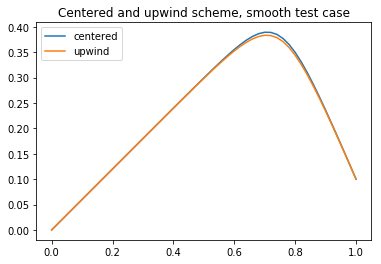

In [20]:
plt.title("Centered and upwind scheme, smooth test case")
plt.plot(X,solution_centered,label="centered")
plt.plot(X,solution_upwind, label="upwind");
plt.legend();

Increasing the drift value yields a boundary layer, which is better resolved by the second order scheme.
(The first order part of the PDE does not correspond anymore to a locally controllable problem.)

Centered discretization
Iteration : 1 , Residue norm : 5.968767847562855
Iteration : 3 , Residue norm : 0.009361990029876921
Iteration : 5 , Residue norm : 1.2185807918285718e-12
Iteration : 7 , Residue norm : 1.532107773982716e-14

Upwind discretization
Iteration : 1 , Residue norm : 2.5464658414200185
Iteration : 3 , Residue norm : 2.2751909174445473e-06
Iteration : 5 , Residue norm : 1.432187701766452e-14
Iteration : 7 , Residue norm : 1.687538997430238e-14


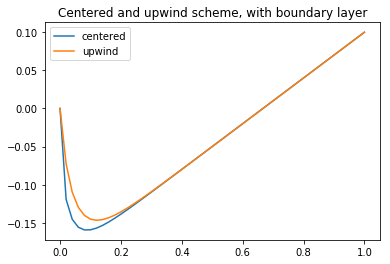

In [21]:
omega2 = 1.3
params = (a,d,omega2,bc,gridScale)
print("Centered discretization"); 
solution_centered = solve_Newton(SchemeCentered,params,guess,print_period=2)
print()
print("Upwind discretization");   
solution_upwind = solve_Newton(SchemeUpwind,params,guess,print_period=2)

plt.title("Centered and upwind scheme, with boundary layer")
plt.plot(X,solution_centered,label="centered")
plt.plot(X,solution_upwind, label="upwind");
plt.legend();

We next remove the second order term, to get the standard eikonal equation.
A problem arises : the jacobian matrix $J$ of the scheme may not be invertible. Fortunately, by degenerate ellipticity, 
$$
    J+\epsilon {\rm Id},
$$
is guaranteed to be invertible, for any $\epsilon>0$. 
(The non-invertibility issue may or may not arise depending on the initial conditions.)

We note in this setting that:
* The centered scheme looses monotonicity, and indeed fails to converge.
* The upwind scheme requires $\epsilon>0$ for solving the linear problems.

Centered discretization
Iteration : 1 , Residue norm : 1.0170748113143362
Iteration : 3 , Residue norm : 8.359333644915653
Iteration : 5 , Residue norm : 0.6737384280319165
Iteration : 7 , Residue norm : 0.6484479686494148
Iteration : 9 , Residue norm : 0.6460149074025576
Iteration : 11 , Residue norm : 0.645771218938006
Iteration : 13 , Residue norm : 0.6457115642020528
Iteration : 15 , Residue norm : 0.6456965949412352
Iteration : 17 , Residue norm : 0.6456928563738735
Iteration : 19 , Residue norm : 0.645691921571347

Upwind discretization
Iteration : 1 , Residue norm : 705.2273268435152
Iteration : 3 , Residue norm : 96.75023856617977
Iteration : 5 , Residue norm : 79.86122878563275
Iteration : 7 , Residue norm : 47.03034794307037
Iteration : 9 , Residue norm : 21.11455744397947
Iteration : 11 , Residue norm : 4.9986847926588895
Iteration : 13 , Residue norm : 0.147575318226002
Iteration : 15 , Residue norm : 0.00010817672836127556
Iteration : 17 , Residue norm : 8.422253220397025e

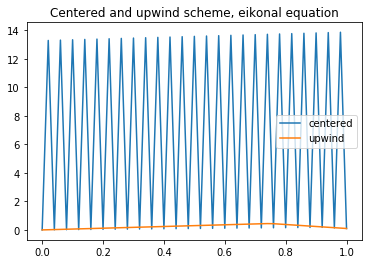

In [22]:
# No second order term
a2=0
params = (a2,d,omega,bc,gridScale)

# Relaxation of the linear problems
epsilon=1
relax = epsilon*ad.Sparse.identity(X.shape)

print("Centered discretization"); 
solution_centered = solve_Newton(SchemeCentered,params,guess,print_period=2,niter=20,relax=relax)
print()
print("Upwind discretization");   
solution_upwind = solve_Newton(SchemeUpwind,params,guess,print_period=2,niter=20,relax=relax)

plt.title("Centered and upwind scheme, eikonal equation")
plt.plot(X,solution_centered,label="centered")
plt.plot(X,solution_upwind, label="upwind");
plt.legend();

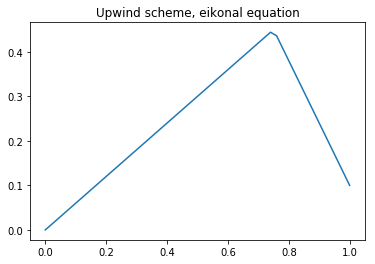

In [23]:
plt.title("Upwind scheme, eikonal equation")
plt.plot(X,solution_upwind);